## Kraskov method 

In Kraskov, the MI $I(X;T)$ between $X$ = input and $T$ = activations is approximated as $H(T)$, the entropy of T : <br>  $$
I(T; X) = H(T) - H(T|X)  \\
= H(T) - H(Z)  \\
= H(T) - c
$$
where $c$ is an unknown constant. <br>
But $H(T)$ has to be computed using the Kraskov estimator:
$$
\frac{d}{P} \left(\sum_{i} \log(r_i + \epsilon)\right) + \frac{d}{2} \log(\pi) - \log \Gamma\left(\frac{d}{2} + 1\right) + \psi(P) - \psi(k)
$$


Paper:<br>
*"Here we focused for simplicity only on the compression
phenomenon in the mutual information between the input and hidden layer activity, leaving aside the
information with respect to the output (as this is not relevant to the compression phenomenon)"* <br>
*"Compression would correspond to decreasing entropy over the
course of training, while a lack of compression would correspond to increasing entropy"*

## Importing stuff

In [9]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

import torch
import torchaudio
import torch.nn as nn
from torch.utils.data import Dataset
from torchsummary import summary

from utils import load
from dataloader import FMA2D_spec
from architectures import SimpleCNN2, ResNet
from simplebinmi import bin_calc_information2

import kde
import keras.backend as K

from Kraskov import kraskov_entropy

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data

In [11]:
DATA_DIR='C:/Users/loren/OneDrive/Bureau/Information theory/information_bottleneck-master/information_bottleneck-master/fma_small'

# download data first from these links:
# curl -O https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
# curl -O https://os.unil.cloud.switch.ch/fma/fma_small.zip

tracks = load('C:/Users/loren/OneDrive/Bureau/Information theory/information_bottleneck-master/information_bottleneck-master/fma_metadata/tracks.csv')
subset = tracks.index[tracks['set', 'subset'] <= 'small']

tracks = tracks.loc[subset][:1000]
train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']

labels_onehot = LabelBinarizer().fit_transform(tracks['track', 'genre_top'])
labels_onehot = pd.DataFrame(labels_onehot, index=tracks.index)

NUM_LABELS = 8
labelixs = {}
y = np.argmax(labels_onehot.to_numpy(), axis=1)  # Add .to_numpy() here
for i in range(NUM_LABELS):
    labelixs[i] = y == i

labelprobs = np.mean(y, axis=0)

## Kraskov method

In [22]:
#data
BATCH = 256
EPOCHS = 100
labels_onehot_np = np.array(labels_onehot)

NUM_LABELS = 8
labelixs = {}
y = np.argmax(labels_onehot_np, axis=1)
for i in range(NUM_LABELS):
    labelixs[i] = y == i

augment_prob = 0.8


# create a training dataset and dataloader
dataset_train = FMA2D_spec(DATA_DIR, train, labels_onehot, transforms=False)
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH, shuffle=True)

# create a validation dataset and dataloader
dataset_valid = FMA2D_spec(DATA_DIR, val, labels_onehot, transforms=False)
val_dataloader = torch.utils.data.DataLoader(dataset_valid, batch_size=BATCH, shuffle=True)

# define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()

# Lee 2017
# SGD optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5)

from utils import plot_spectrogram
for spec, label, ixs in dataloader:
    #print(spec.size())
    #print(len(label))
    #print(ixs)
    #plot_spectrogram(spec[0])
    input_size = spec.size()[2]
    break

### Plotting MI I(X;T) for different Convolutional blocks

[1,   768 subsamples] Training loss: 2.011
[EPOCH 1, 0.0208 min] Validation Loss: 1.9408 | Validation Accuracy: 0.3038 | Training Accuracy: 0.2234
[2,  1536 subsamples] Training loss: 1.941
[EPOCH 2, 0.0514 min] Validation Loss: 1.9139 | Validation Accuracy: 0.3165 | Training Accuracy: 0.2549
[3,  2304 subsamples] Training loss: 1.890
[EPOCH 3, 0.0816 min] Validation Loss: 1.8892 | Validation Accuracy: 0.4177 | Training Accuracy: 0.3114
[4,  3072 subsamples] Training loss: 1.843
[EPOCH 4, 0.1121 min] Validation Loss: 1.8601 | Validation Accuracy: 0.4430 | Training Accuracy: 0.3771
[5,  3840 subsamples] Training loss: 1.790
[EPOCH 5, 0.1423 min] Validation Loss: 1.8141 | Validation Accuracy: 0.3671 | Training Accuracy: 0.4205
[6,  4608 subsamples] Training loss: 1.746
[EPOCH 6, 0.1729 min] Validation Loss: 1.7652 | Validation Accuracy: 0.3924 | Training Accuracy: 0.4323
[7,  5376 subsamples] Training loss: 1.698
[EPOCH 7, 0.2040 min] Validation Loss: 1.7120 | Validation Accuracy: 0.4304

[57, 43776 subsamples] Training loss: 1.047
[EPOCH 57, 1.8859 min] Validation Loss: 1.4878 | Validation Accuracy: 0.5190 | Training Accuracy: 0.6465
[58, 44544 subsamples] Training loss: 1.039
[EPOCH 58, 1.9184 min] Validation Loss: 1.5015 | Validation Accuracy: 0.5316 | Training Accuracy: 0.6452
[59, 45312 subsamples] Training loss: 1.015
[EPOCH 59, 1.9517 min] Validation Loss: 1.4807 | Validation Accuracy: 0.5190 | Training Accuracy: 0.6439
[60, 46080 subsamples] Training loss: 1.021
[EPOCH 60, 1.9848 min] Validation Loss: 1.5004 | Validation Accuracy: 0.4810 | Training Accuracy: 0.6478
[61, 46848 subsamples] Training loss: 1.004
[EPOCH 61, 2.0174 min] Validation Loss: 1.5060 | Validation Accuracy: 0.5190 | Training Accuracy: 0.6610
[62, 47616 subsamples] Training loss: 1.004
[EPOCH 62, 2.0502 min] Validation Loss: 1.5559 | Validation Accuracy: 0.4430 | Training Accuracy: 0.6491
[63, 48384 subsamples] Training loss: 0.997
[EPOCH 63, 2.0845 min] Validation Loss: 1.4797 | Validation Ac

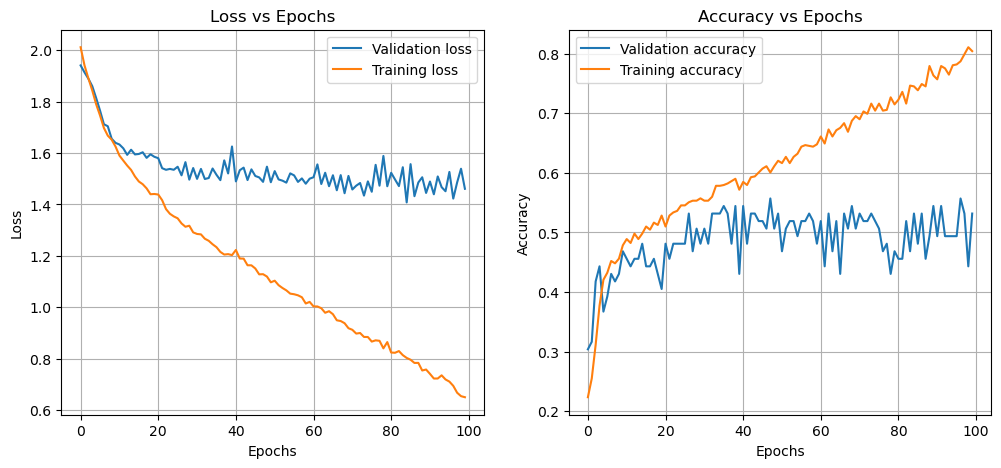

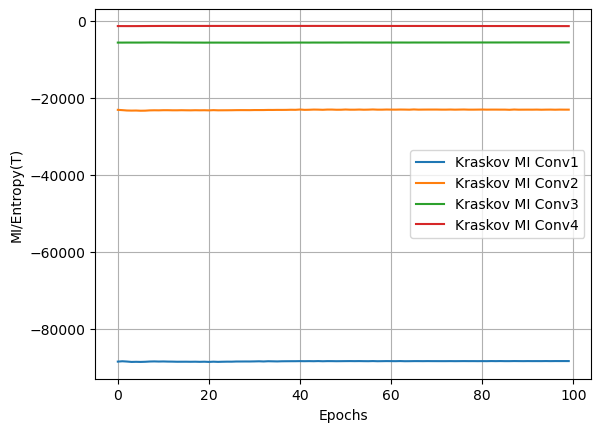

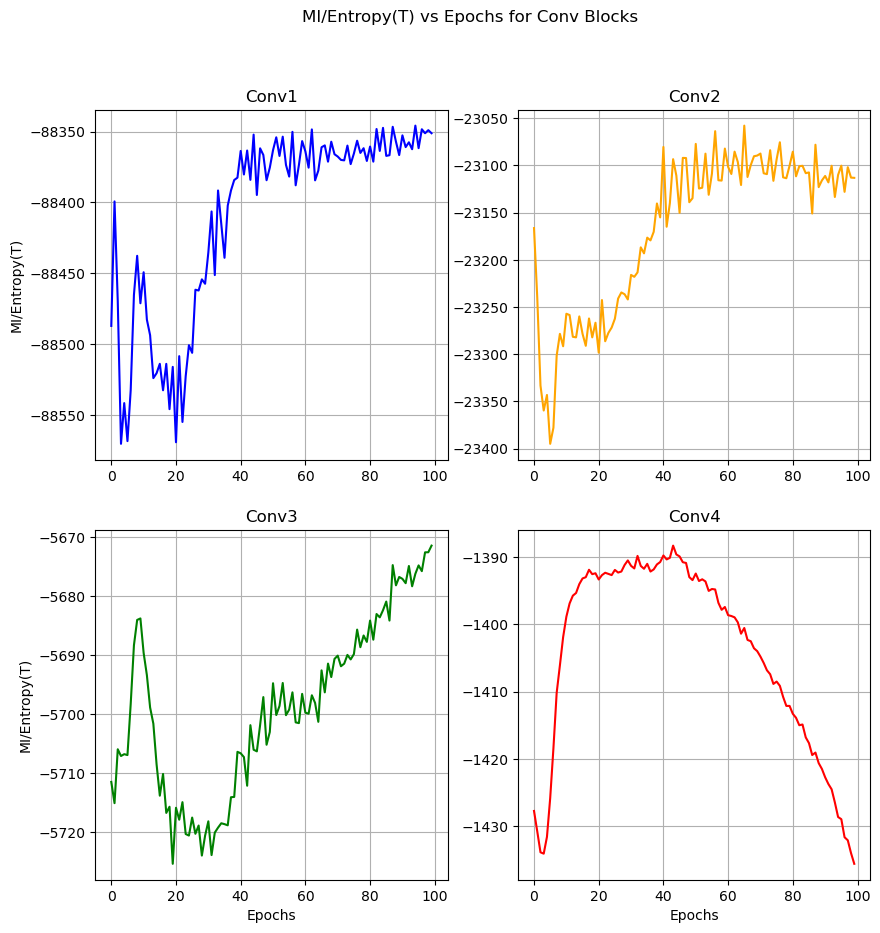

Finished Training


In [23]:
p_dropout = 0.3
#model = ResNet(FN=64, p_dropout=p_dropout)
#added a condition to allow to specify ReLU or tanh
model = SimpleCNN2(activation = "tanh")
model.to(device)


#summary(model, (1, 128, 1290))

# Adam optimizer01
lr = 0.01
optimizer = torch.optim.Adam(model.parameters())

timestamp = time.strftime("apr%d_t%H%M", time.gmtime())
model_name = f"{model.name}_B{BATCH}_E{EPOCHS}_LR{lr}_pD{p_dropout}_A{augment_prob}_{timestamp}"

i = 0
running_loss = 0.0
best_val_loss = float('inf')  # initialize the best validation loss

# train the model
acc_tr = []
acc_val = []
loss_tr = []
loss_val = []

mi_array_a1 = []
mi_array_a2 = []
mi_array_a3 = []
mi_array_a4 = []

activity = np.zeros((1000, 4, 10304))
activity2 = np.zeros((1000, 16, 2576))
activity3 = np.zeros((1000, 32, 648))
activity4 = np.zeros((1000, 64, 164))

t0 = time.time()
prev_a = 0


for epoch in range(EPOCHS):
    # evaluate the model on the training dataset
    train_correct = 0
    train_total = 0
    for spectrogram, label, ixs in dataloader:
        model.train()
        label = label.to(device)
        train_label = torch.argmax(label, dim=1)

        # forward pass
        spectrogram = spectrogram.squeeze(0)
        spectrogram = spectrogram.unsqueeze(1)

        spectrogram = spectrogram.to(device)
        output, a1, a2,a3 ,a4 = model(spectrogram)
        activity[ixs] = a1.cpu().detach().numpy()
        activity2[ixs] = a2.cpu().detach().numpy()
        activity3[ixs] = a3.cpu().detach().numpy()
        activity4[ixs] = a4.cpu().detach().numpy()
                
        loss = loss_fn(output, label)


        # backward pass
        optimizer.zero_grad()
        model.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the learning rate
        # scheduler.step(loss)

        _, train_predicted = torch.max(output.data, 1)
        train_total += train_label.size(0)
        train_correct += (train_predicted == train_label).sum().item()
        # print statistics
        i += 1
        running_loss += loss.item()

    loss = running_loss / len(dataloader)
    loss_tr.append(loss)
    print('[%d, %5d subsamples] Training loss: %.3f' % (epoch + 1, i * BATCH, loss))
    running_loss = 0
    # evaluate the model on the validation dataset
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    model.eval()
    with torch.no_grad():
        for val_spectrogram, val_label, ixs in val_dataloader:
            val_label = val_label.to(device)
            val_label = torch.argmax(val_label, dim=1)

            val_spectrogram = val_spectrogram.squeeze(0)
            val_spectrogram = val_spectrogram.unsqueeze(1)
            val_spectrogram = val_spectrogram.to(device)
            val_output, a1, a2, _, _ = model(val_spectrogram)
            val_loss += loss_fn(val_output, val_label).item()
            _, val_predicted = torch.max(val_output.data, 1)
            val_total += val_label.size(0)
            val_correct += (val_predicted == val_label).sum().item()

    loss = val_loss / len(val_dataloader)
    loss_val.append(loss)
    val_acc = val_correct / val_total
    tr_acc = train_correct / train_total
    acc_tr.append(tr_acc)
    acc_val.append(val_acc)
    t1 = time.time()
    t = (t1 - t0) / 60
    # Save the model if the validation loss is the best seen so far
    if loss < best_val_loss:
        best_val_loss = loss
        best_val_acc = val_acc
        best_tr_acc = tr_acc
        best_state_dict = model.state_dict()
    print(
        '[EPOCH {}, {:.4f} min] Validation Loss: {:.4f} | Validation Accuracy: {:.4f} | Training Accuracy: {:.4f}'.format(epoch+1, t, loss,
                                                                                                                val_acc,
                                                                                                                tr_acc))
    # Compute the MI using kraskov_MI2 for activations a1 and a2
    # NOTE: we are computing the MI wrt to the first (0th) feature map, could do for others aswell
    mi_a1 = kraskov_entropy(activity[:, 0, :], k=2)
    mi_a2 = kraskov_entropy(activity2[:, 0, :], k=2)
    mi_a3 = kraskov_entropy(activity3[:, 0, :], k=2)
    mi_a4 = kraskov_entropy(activity4[:, 0, :], k=2)
    
    mi_array_a1.append(mi_a1)
    mi_array_a2.append(mi_a2)
    mi_array_a3.append(mi_a3)
    mi_array_a4.append(mi_a4)


mi_array_a1 = np.array(mi_array_a1)
mi_array_a2 = np.array(mi_array_a2)
mi_array_a3 = np.array(mi_array_a3)
mi_array_a4 = np.array(mi_array_a4)

np.save(timestamp + '_MI_a1', mi_array_a1)
np.save(timestamp + '_MI_a2', mi_array_a2)
np.save(timestamp + '_MI_a3', mi_array_a3)
np.save(timestamp + '_MI_a4', mi_array_a4)


#plotting

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_val, label='Validation loss')
plt.plot(loss_tr, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.title('Loss vs Epochs')

plt.subplot(1, 2, 2)
plt.plot(acc_val, label='Validation accuracy')
plt.plot(acc_tr, label='Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy vs Epochs')

plt.show()

t = np.arange(len(mi_array_a1))
plt.plot(t, mi_array_a1, label='Kraskov MI Conv1')
plt.plot(t, mi_array_a2, label='Kraskov MI Conv2')
plt.plot(t, mi_array_a3, label='Kraskov MI Conv3')
plt.plot(t, mi_array_a4, label='Kraskov MI Conv4')

plt.xlabel('Epochs')
plt.ylabel('MI/Entropy(T)')
plt.grid()
plt.legend()
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('MI/Entropy(T) vs Epochs for Conv Blocks')

axs[0, 0].plot(t, mi_array_a1, label='Kraskov MI Conv1', color='blue')
axs[0, 0].set_title('Conv1')
axs[0, 0].grid()
axs[0, 0].set(ylabel='MI/Entropy(T)')

axs[0, 1].plot(t, mi_array_a2, label='Kraskov MI Conv2', color='orange')
axs[0, 1].set_title('Conv2')
axs[0, 1].grid()

axs[1, 0].plot(t, mi_array_a3, label='Kraskov MI Conv3', color='green')
axs[1, 0].set_title('Conv3')
axs[1, 0].grid()
axs[1, 0].set(xlabel='Epochs', ylabel='MI/Entropy(T)')

axs[1, 1].plot(t, mi_array_a4, label='Kraskov MI Conv4', color='red')
axs[1, 1].set_title('Conv4')
axs[1, 1].grid()
axs[1, 1].set(xlabel='Epochs')

plt.show()

torch.save(best_state_dict, model_name + f'_VAL{best_val_acc}_TRAIN{best_tr_acc}.pt')
print('Finished Training')

In [14]:
activity.shape

(1000, 4, 10304)

In [24]:
a = activity[:, 0, :].shape
a

(1000, 10304)

In [15]:
activity2.shape

(1000, 16, 2576)

In [16]:
activity3.shape

(1000, 32, 648)

In [17]:
activity4.shape

(1000, 64, 164)

In [9]:
activity4.shape

(1000, 64, 164)

## Plotting MI for different feature maps

In [24]:
import os

# Create a directory to save the plots
plot_dir = "Kraskov_plots"
os.makedirs(plot_dir, exist_ok=True)

[1,   768 subsamples] Training loss: 2.072
[EPOCH 1, 0.0211 min] Validation Loss: 2.0212 | Validation Accuracy: 0.3418 | Training Accuracy: 0.1721
[2,  1536 subsamples] Training loss: 1.995
[EPOCH 2, 0.0673 min] Validation Loss: 1.9667 | Validation Accuracy: 0.3671 | Training Accuracy: 0.2326
[3,  2304 subsamples] Training loss: 1.945
[EPOCH 3, 0.1150 min] Validation Loss: 1.9464 | Validation Accuracy: 0.3418 | Training Accuracy: 0.2957
[4,  3072 subsamples] Training loss: 1.894
[EPOCH 4, 0.1628 min] Validation Loss: 1.9189 | Validation Accuracy: 0.3924 | Training Accuracy: 0.3233
[5,  3840 subsamples] Training loss: 1.847
[EPOCH 5, 0.2089 min] Validation Loss: 1.8916 | Validation Accuracy: 0.3291 | Training Accuracy: 0.3706
[6,  4608 subsamples] Training loss: 1.806
[EPOCH 6, 0.2579 min] Validation Loss: 1.8537 | Validation Accuracy: 0.3418 | Training Accuracy: 0.3890
[7,  5376 subsamples] Training loss: 1.767
[EPOCH 7, 0.3047 min] Validation Loss: 1.8267 | Validation Accuracy: 0.3797

[57, 43776 subsamples] Training loss: 1.072
[EPOCH 57, 2.8720 min] Validation Loss: 1.6058 | Validation Accuracy: 0.4177 | Training Accuracy: 0.6452
[58, 44544 subsamples] Training loss: 1.063
[EPOCH 58, 2.9221 min] Validation Loss: 1.6098 | Validation Accuracy: 0.4304 | Training Accuracy: 0.6229
[59, 45312 subsamples] Training loss: 1.069
[EPOCH 59, 2.9739 min] Validation Loss: 1.5307 | Validation Accuracy: 0.4557 | Training Accuracy: 0.6334
[60, 46080 subsamples] Training loss: 1.043
[EPOCH 60, 3.0261 min] Validation Loss: 1.5833 | Validation Accuracy: 0.4304 | Training Accuracy: 0.6426
[61, 46848 subsamples] Training loss: 1.033
[EPOCH 61, 3.0817 min] Validation Loss: 1.5787 | Validation Accuracy: 0.4684 | Training Accuracy: 0.6491
[62, 47616 subsamples] Training loss: 1.028
[EPOCH 62, 3.1348 min] Validation Loss: 1.5402 | Validation Accuracy: 0.4557 | Training Accuracy: 0.6570
[63, 48384 subsamples] Training loss: 1.037
[EPOCH 63, 3.1857 min] Validation Loss: 1.6145 | Validation Ac

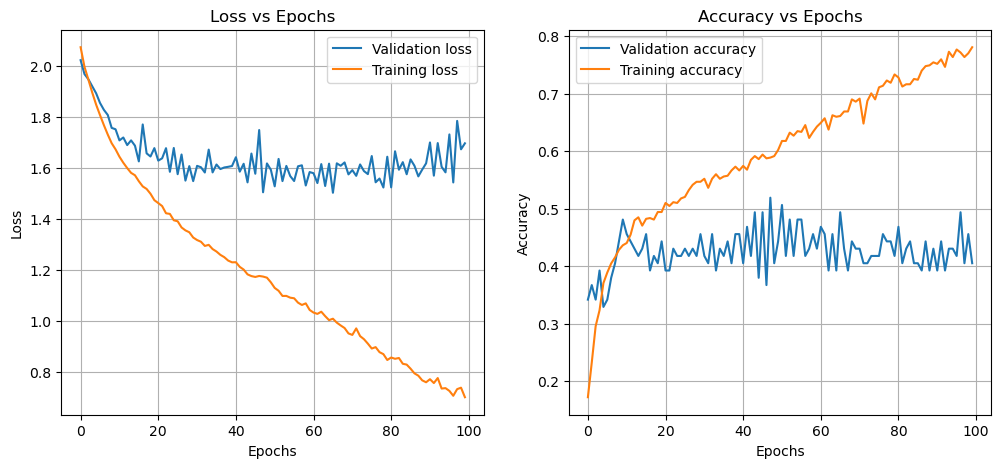

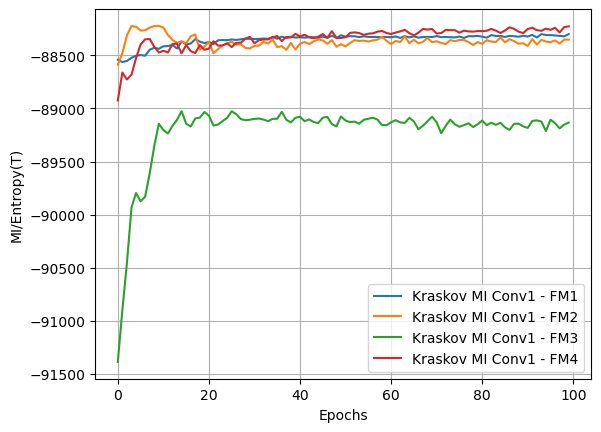

Finished Training


In [25]:
EPOCHS = 100
p_dropout = 0.3
#model = ResNet(FN=64, p_dropout=p_dropout)
#added a condition to allow to specify ReLU or tanh
model = SimpleCNN2(activation = "tanh")
model.to(device)


#summary(model, (1, 128, 1290))

# Adam optimizer01
lr = 0.01
optimizer = torch.optim.Adam(model.parameters())

timestamp = time.strftime("apr%d_t%H%M", time.gmtime())
model_name = f"{model.name}_B{BATCH}_E{EPOCHS}_LR{lr}_pD{p_dropout}_A{augment_prob}_{timestamp}"

i = 0
running_loss = 0.0
best_val_loss = float('inf')  # initialize the best validation loss

# train the model
acc_tr = []
acc_val = []
loss_tr = []
loss_val = []

mi_array_a1_fm1 = []
mi_array_a1_fm2 = []
mi_array_a1_fm3 = []
mi_array_a1_fm4 = []


activity = np.zeros((1000, 4, 10304))
activity2 = np.zeros((1000, 16, 2576))
activity3 = np.zeros((1000, 32, 648))
activity4 = np.zeros((1000, 64, 164))

t0 = time.time()
prev_a = 0


for epoch in range(EPOCHS):
    # evaluate the model on the training dataset
    train_correct = 0
    train_total = 0
    for spectrogram, label, ixs in dataloader:
        model.train()
        label = label.to(device)
        train_label = torch.argmax(label, dim=1)

        # forward pass
        spectrogram = spectrogram.squeeze(0)
        spectrogram = spectrogram.unsqueeze(1)

        spectrogram = spectrogram.to(device)
        output, a1, a2,a3 ,a4 = model(spectrogram)
        activity[ixs] = a1.cpu().detach().numpy()
        activity2[ixs] = a2.cpu().detach().numpy()
        activity3[ixs] = a3.cpu().detach().numpy()
        activity4[ixs] = a4.cpu().detach().numpy()

        loss = loss_fn(output, label)


        # backward pass
        optimizer.zero_grad()
        model.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the learning rate
        # scheduler.step(loss)

        _, train_predicted = torch.max(output.data, 1)
        train_total += train_label.size(0)
        train_correct += (train_predicted == train_label).sum().item()
        # print statistics
        i += 1
        running_loss += loss.item()

    loss = running_loss / len(dataloader)
    loss_tr.append(loss)
    print('[%d, %5d subsamples] Training loss: %.3f' % (epoch + 1, i * BATCH, loss))
    running_loss = 0
    # evaluate the model on the validation dataset
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    model.eval()
    with torch.no_grad():
        for val_spectrogram, val_label, ixs in val_dataloader:
            val_label = val_label.to(device)
            val_label = torch.argmax(val_label, dim=1)

            val_spectrogram = val_spectrogram.squeeze(0)
            val_spectrogram = val_spectrogram.unsqueeze(1)
            val_spectrogram = val_spectrogram.to(device)
            val_output, a1, a2, _, _ = model(val_spectrogram)
            val_loss += loss_fn(val_output, val_label).item()
            _, val_predicted = torch.max(val_output.data, 1)
            val_total += val_label.size(0)
            val_correct += (val_predicted == val_label).sum().item()

    loss = val_loss / len(val_dataloader)
    loss_val.append(loss)
    val_acc = val_correct / val_total
    tr_acc = train_correct / train_total
    acc_tr.append(tr_acc)
    acc_val.append(val_acc)
    t1 = time.time()
    t = (t1 - t0) / 60
    # Save the model if the validation loss is the best seen so far
    if loss < best_val_loss:
        best_val_loss = loss
        best_val_acc = val_acc
        best_tr_acc = tr_acc
        best_state_dict = model.state_dict()
    print(
        '[EPOCH {}, {:.4f} min] Validation Loss: {:.4f} | Validation Accuracy: {:.4f} | Training Accuracy: {:.4f}'.format(epoch+1, t, loss,
                                                                                                                val_acc,
                                                                                                                tr_acc))
    # Compute the MI using kraskov_MI2 for activations a1 and a2
    # NOTE: we are computing the MI wrt to the first (0th) feature map, could do for others aswell
    mi_a1_fm1 = kraskov_entropy(activity[:, 0, :], k=2)
    mi_a1_fm2 = kraskov_entropy(activity[:, 1, :], k=2)
    mi_a1_fm3 = kraskov_entropy(activity[:, 2, :], k=2)
    mi_a1_fm4 = kraskov_entropy(activity[:, 3, :], k=2)

    mi_array_a1_fm1.append(mi_a1_fm1)
    mi_array_a1_fm2.append(mi_a1_fm2)
    mi_array_a1_fm3.append(mi_a1_fm3)
    mi_array_a1_fm4.append(mi_a1_fm4)



mi_array_a1_fm1 = np.array(mi_array_a1_fm1)
mi_array_a1_fm2 = np.array(mi_array_a1_fm2)
mi_array_a1_fm3 = np.array(mi_array_a1_fm3)
mi_array_a1_fm4 = np.array(mi_array_a1_fm4)

np.save(timestamp + '_MI_a1_fm1', mi_array_a1_fm1)
np.save(timestamp + '_MI_a1_fm2', mi_array_a1_fm2)
np.save(timestamp + '_MI_a1_fm3', mi_array_a1_fm3)
np.save(timestamp + '_MI_a1_fm4', mi_array_a1_fm4)


num_samples = 1000

# Save the combined loss and accuracy plot
combined_plot_filename = os.path.join(plot_dir, f'combined_plot_epochs{EPOCHS}_samples{num_samples}.png')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_val, label='Validation loss')
plt.plot(loss_tr, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.title('Loss vs Epochs')

plt.subplot(1, 2, 2)
plt.plot(acc_val, label='Validation accuracy')
plt.plot(acc_tr, label='Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.title('Accuracy vs Epochs')

plt.savefig(combined_plot_filename)
plt.show()


# Save the MI plot
mi_plot_filename = os.path.join(plot_dir, f'mi_plot_epochs{EPOCHS}_samples{num_samples}.png')
t = np.arange(len(mi_array_a1_fm1))
plt.plot(t, mi_array_a1_fm1, label='Kraskov MI Conv1 - FM1')
plt.plot(t, mi_array_a1_fm2, label='Kraskov MI Conv1 - FM2')
plt.plot(t, mi_array_a1_fm3, label='Kraskov MI Conv1 - FM3')
plt.plot(t, mi_array_a1_fm4, label='Kraskov MI Conv1 - FM4')
plt.xlabel('Epochs')
plt.ylabel('MI/Entropy(T)')
plt.grid()
plt.legend()
plt.savefig(mi_plot_filename)
plt.show()



torch.save(best_state_dict, model_name + f'_VAL{best_val_acc}_TRAIN{best_tr_acc}.pt')
print('Finished Training')